In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
import zarr

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/lat_lon_scalar.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dl = xr.open_zarr(store=store3, consolidated=True)

In [3]:
zonal = dl.d_zonal
merd = dl.d_merd

In [7]:
d = dv.mbathy
u = dv.vozocrtx
v = dv.vomecrty
vel = np.sqrt(u**2 + v**2)

In [20]:
d_hbx = d.isel(y=slice(0,899)).diff(dim='x')
d_hbx = d_hbx.squeeze(axis=0)
d_hby = d.isel(x=slice(0,1199)).diff(dim='y')
d_hby = d_hby.squeeze(axis=0)

len_bat = np.sqrt((d_hbx/zonal)**2 + (d_hby/merd)**2)

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


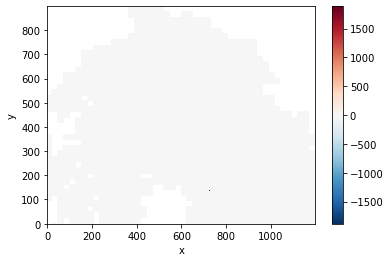

In [19]:
len_bat.plot()

503 502
638 300
871 602
820 200
520 350


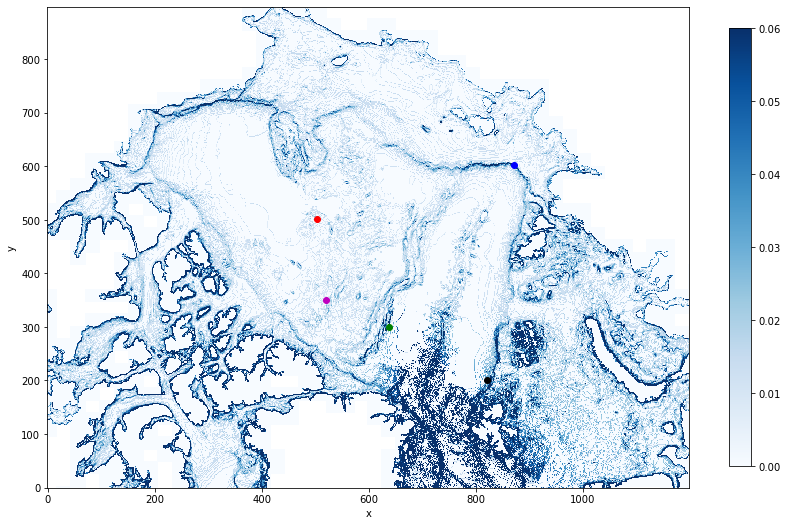

In [27]:
warnings.simplefilter("ignore")
punkt_list = [(503,502), (638,300), (871,602), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(12,9))
c_list = ['r', 'g', 'b', 'k', 'm']

cmap = plt.get_cmap('Blues')
c = len_bat.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False)
for p in range(len((punkt_list))):
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])
    
fig.colorbar(c,
             shrink=0.7,
             #label=r"Depth [m]"
            )
axs.set_aspect('equal')
fig.tight_layout()

503 502
638 300
871 602
820 200
520 350


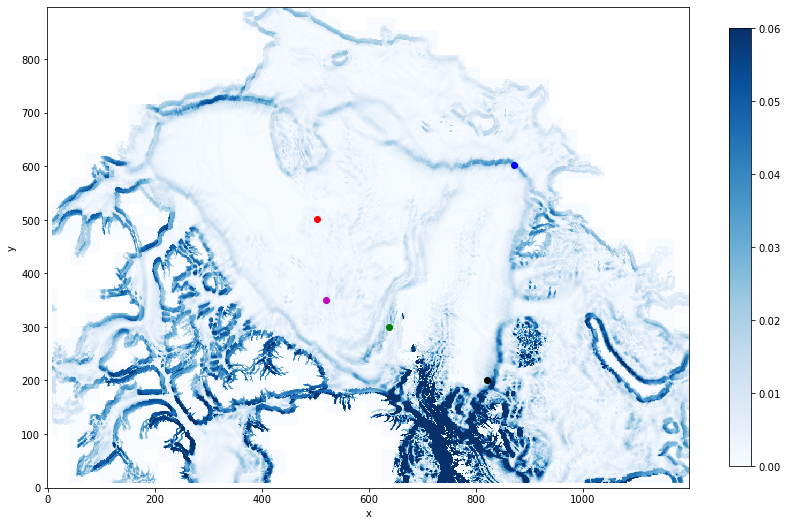

In [28]:
'Glatte bathymetrien først'
warnings.simplefilter("ignore")

d_hbxg = d_hbx.rolling(x= 10,).mean()
d_hbyg = d_hby.rolling(y= 10,).mean()

len_batg = np.sqrt((d_hbxg/zonal)**2 + (d_hbyg/merd)**2)

punkt_list = [(503,502), (638,300), (871,602), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(12,9))
c_list = ['r', 'g', 'b', 'k', 'm']

cmap = plt.get_cmap('Blues')
c = len_batg.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False)
for p in range(len((punkt_list))):
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])
fig.colorbar(c,
             shrink=0.7,
             #label=r"Depth [m]"
            )    
axs.set_aspect('equal')
fig.tight_layout()

'zoomed in to see resolutin'
punkt_list = [(53,52), (38,50), (71,52), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(20,15))

cmap = plt.get_cmap('magma_r')
c = len_bat.isel(x=slice(450,550),y=slice(450,550)).plot(vmin=0, vmax=0.06, cmap=cmap)

pp = punkt_list[0]
print(pp[0], pp[1]) 
axs.plot(pp[0],pp[1] ,marker = 'o' ,color = 'b')
axs.set_aspect('equal')

In [10]:
for p in punkt_list:
    pp = p
    y=pp[1]
    x=pp[0]
    print(pp[0], pp[1])
    d_hbx_p = d_hbx.isel(y=y, x=x)
    d_hby_p = d_hby.isel(y=y, x=x)
    zonalp = zonal.isel(x=x,y=y)
    merdp = merd.isel(x=x, y=y)
    print('-------------------')
    print((d_hbx_p/zonalp).values, (d_hby_p/merdp).values)
    print('new point')

503 502
-------------------
-0.0 0.012180641
new point
638 300
-------------------
-0.023390058 -0.011324999
new point
871 602
-------------------
-0.031962655 -0.038862083
new point
820 200
-------------------
-0.032732025 0.0
new point
520 350
-------------------
0.009189493 0.0
new point


In [17]:
'Weigthing the levels'
z = dzz.gdept_1d.isel(t=0)
dz = np.gradient(z)

In [23]:
'Making a function for the vertical PC'
def PCz(x,y):
    up = u.isel(y=y, x=x)
    vp = v.isel(y=y, x=x)

    zonalp = zonal.isel(y=y, x=x)
    merdp = merd.isel(y=y, x=x)

    d_hbx_p = d_hbxg.isel(y=y, x=x)
    d_hby_p = d_hbyg.isel(y=y, x=x)
    
    # lag lengde scalar av bathym og dele u_o og u_p på 

    vel_ort = ((up*(d_hbx_p/zonalp) + vp*(d_hby_p/merdp))/np.sqrt(d_hbx_p**2 + d_hby_p**2))*np.sqrt(dz) # delt på lengden av bathymetrien
    vel_par = ((up*(d_hby_p/merdp)  - vp*(d_hbx_p/zonalp))/np.sqrt(d_hbx_p**2 + d_hby_p**2))*np.sqrt(dz)
    
    d_p = d.isel(y=y, x=x).values
    dyp_o = vel_ort.isel(depth = slice(0,int(d_p)-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dyp_p = vel_par.isel(depth = slice(0,int(d_p)-1))

    cov_o = np.cov(dyp_o.T, bias=True) # uten .T ble den en 73x73 matrise 
    cov_p = np.cov(dyp_p.T, bias=True)
    
    values_o, vectors_o = np.linalg.eig(cov_o)
    order_o = values_o.argsort()[::-1]
    values_o, vectors_o = values_o[order_o], vectors_o[:, order_o]
    values_p, vectors_p = np.linalg.eig(cov_p)
    order_p = values_p.argsort()[::-1]
    values_p, vectors_p = values_p[order_p], vectors_p[:, order_p]
    
    PCp = (np.sqrt(values_p[0])*vectors_p[:,0])*(1/np.sqrt(dz[:int(d_p)-1]))
    PCo = (np.sqrt(values_o[0])*vectors_o[:,0])*(1/np.sqrt(dz[:int(d_p)-1]))
    
    return PCp, PCo, dyp_p, dyp_o

503 502
638 300
871 602
820 200
520 350


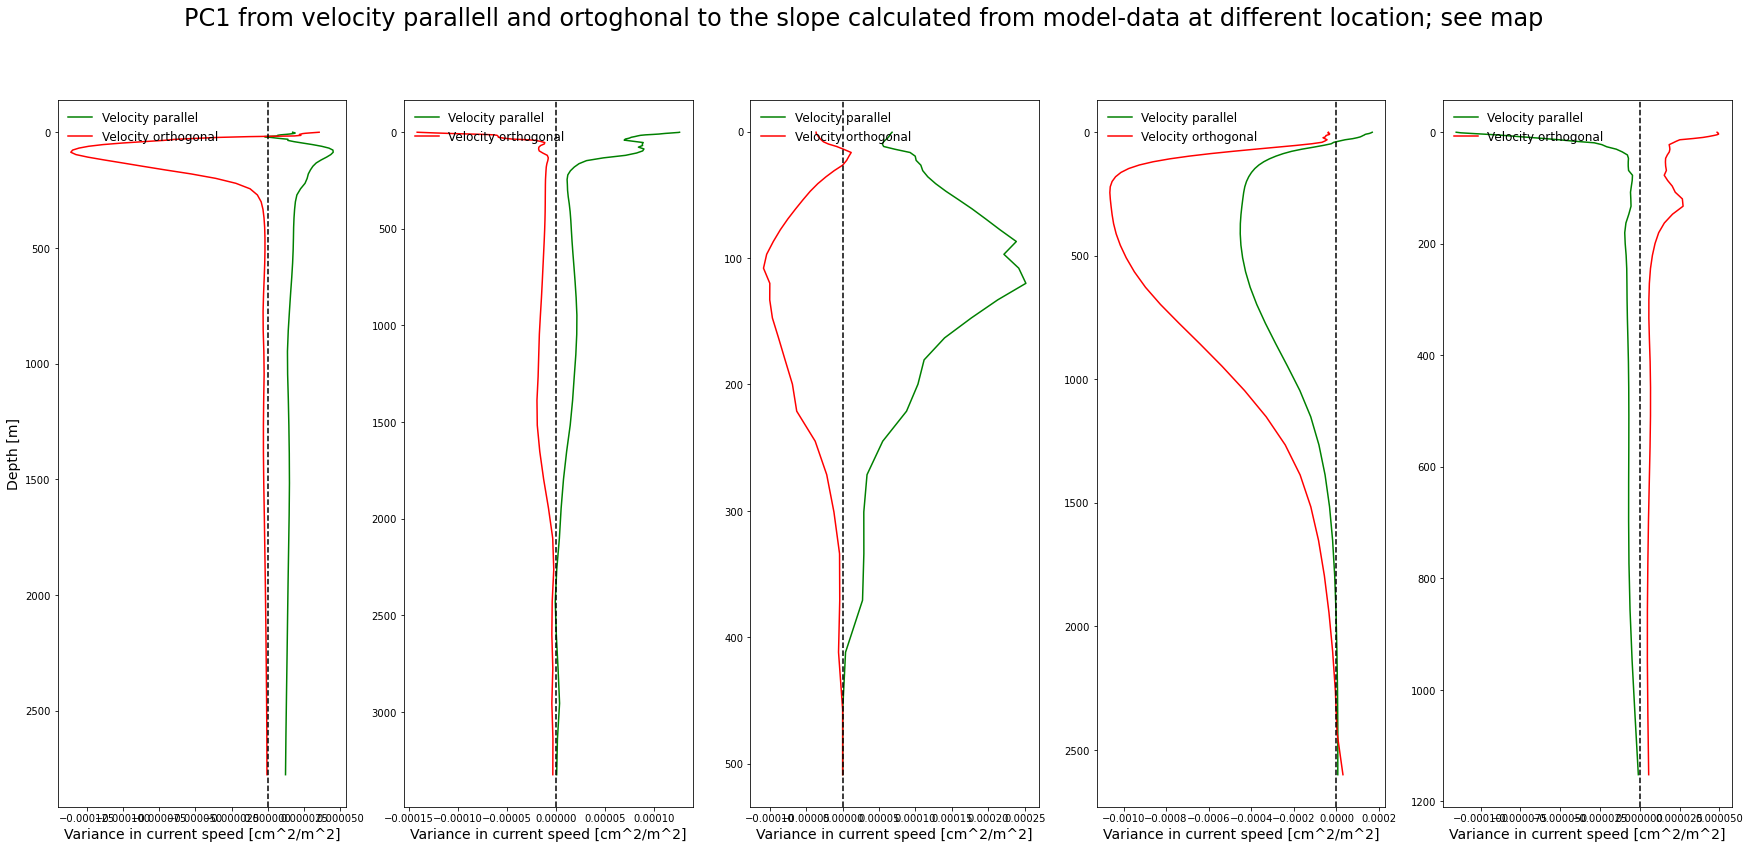

In [25]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (30,13))
plt.suptitle('PC1 from velocity parallell and ortoghonal to the slope calculated from model-data at different location; see map ', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    PCp, PCo, dypp, dypo = PCz(pp[0],pp[1])
        
    axs.plot(PCp,dypp.depth, 'g', label = 'Velocity parallel')
    axs.plot(PCo,dypo.depth, 'r', label = 'Velocity orthogonal')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=12, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
